Классификация и детекция кошечек и собак
В этом варианте использую предобученную модель FasterRCNN_Resnet50

Снова обновляем модуль до необходимой версии

In [1]:
pip uninstall albumentations

Uninstalling albumentations-0.1.12:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/albumentations-0.1.12.dist-info/*
    /usr/local/lib/python3.7/dist-packages/albumentations/*
Proceed (y/n)? y
  Successfully uninstalled albumentations-0.1.12


In [2]:
pip install albumentations # package >= '0.5.1'

     |████████████████████████████████| 81kB 3.6MB/s 
     |████████████████████████████████| 37.6MB 83kB/s 
     |████████████████████████████████| 952kB 31.8MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [1]:
import albumentations as A
A.__version__

'0.5.2'

In [4]:
# монтируем гугл диск с данными
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
!unzip -q /content/gdrive/MyDrive/cats_dogs_dataset.zip

In [2]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [3]:
import numpy as np
import pandas as pd
import os
from os import path

from sklearn.model_selection import train_test_split

import cv2
import matplotlib.pyplot as plt

from torch.utils.data import Dataset , DataLoader

import time
import datetime

In [4]:
# загрузим гогтовый датасет
cats_dogs_data = pd.read_csv('/content/gdrive/MyDrive/cats_dogs_data.csv')

Загружаем модель предобученную на датасете COCO

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
model_torch = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)

Сразу создам даталоадер на основе датафрейма

In [6]:
from cd_dataset import Cats_and_Dogs
train_dataset = Cats_and_Dogs(cats_dogs_data, False)

In [7]:
X = cats_dogs_data.idx
y = cats_dogs_data.target

train_idx, val_idx, _, _ = train_test_split(X, y, test_size = 0.2, stratify = y)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size = 24, sampler = train_idx, collate_fn = collate_fn)
valid_loader =  DataLoader(train_dataset, batch_size = 24, sampler = val_idx, collate_fn = collate_fn)

**Теперь попробуем модель в действии:**
По выбранной картинке сделаем детекцию объектов, для этого загрузим необходимые бибилиотеки и сначала прост посмотрим на изображение

In [8]:
from utils import show_random_pict, plot_img_fastrcnn

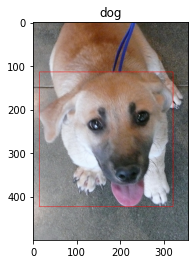

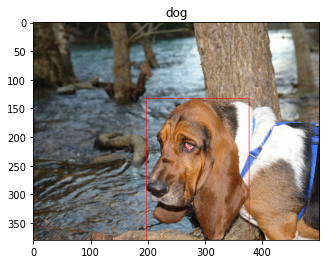

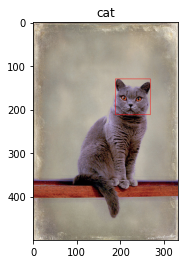

In [14]:
# вспомним как выглядят картинки в данных
for i in range(3):
    show_random_pict(cats_dogs_data)

**Делаем предсказание на предобученной модели**
для этого берем случайную картинку

In [14]:
random_image = np.random.choice(range(len(cats_dogs_data)))
img_path = cats_dogs_data.loc[random_image].img_name

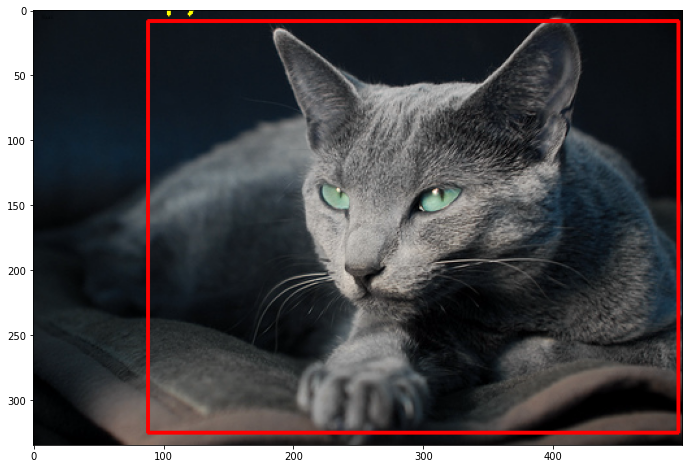

In [15]:
img_with_boxes = plot_img_fastrcnn(img_path, model_torch)
fig = plt.figure(figsize=(18,8))
plt.imshow(img_with_boxes.astype('uint'));

Итак, опробовали предобученную модель. Работает она хорошо, предсказывает разные классы и достаточно хорошо детектирует их на изображениях. Теперь необходимо переучить ее с датасета COCO на новый датасет, чтоб модель детектировала и классифицировала только нужные нам объекты. 

In [9]:
# используемые классы
class_names ={'Cat': 1, 'Dog': 0}
#n_classes = 2

In [10]:
# вот такой получился датафрейм картинок (как и в прошлой работе)
cats_dogs_data.head(5)

,idx,img_name,target,xmin,ymin,xmax,ymax
0,0,data/Abyssinian_1.jpg,1,333,72,425,158
1,1,data/Abyssinian_10.jpg,1,72,105,288,291
2,2,data/Abyssinian_100.jpg,1,151,71,335,267
3,3,data/Abyssinian_101.jpg,1,54,36,319,235
4,4,data/Abyssinian_102.jpg,1,23,27,325,320


Следующий этап:
**Создание своей модели**, которую будем обучать

In [11]:
def create_model(pretrain = True):
    # та же модель что была в начале ноутбука
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrain)
    # количество классов которое нам нужно
    num_classes = 2

    # получаем входные характеристики классификатора
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # и меняем предобученную "голову" сетки
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

Я взял **не** предобученную модель для наглядности изменения метрик в процессе обучения.
Так же часть эксперимента поставлена на уже предобученной на датасете СОСО модели.

In [12]:
# создаем или загружаем сохраненную модель, объявляем оптимизатор
my_model = create_model(pretrain = False).to(device)  # создаем новую модель предобученную на датасете COCO
#model = my_model(pretrain = False).to(device)  # создаем новую модель не обученную

optimizer = torch.optim.SGD(my_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

In [13]:
# Для идентификации меток переделаем словарь классов
rev_label_map = {v: k for k, v in class_names.items()}

**Функции обучения модели**

In [14]:
from train_val import train_frcnn, validate_frcnn

In [15]:
num_epochs = 7
for epoch in range(1, num_epochs + 1):
    start = time.time()
    train_loss = train_frcnn(train_loader, my_model, optimizer, device)
    mean_acc, mean_iou = validate_frcnn(valid_loader, my_model, device)
    print(f"Эпоха #{epoch} train_loss: {train_loss}, mean accuracy: {mean_acc}, mIoU: {mean_iou}")   
    end = time.time()
    print("Время затрачено на эпоху : ", str(datetime.timedelta(seconds=(end - start))))
    print()
print(f"Размер тренировочного сета : {len(train_idx)}, валидационного сета : {len(val_idx)}")

RuntimeError: ignored

Посмотрим предсказание модели на случайной картинке из валидционной выборки

In [17]:
random_image = np.random.choice(range(len(val_idx)))
img_path = cats_dogs_data.loc[random_image].img_name

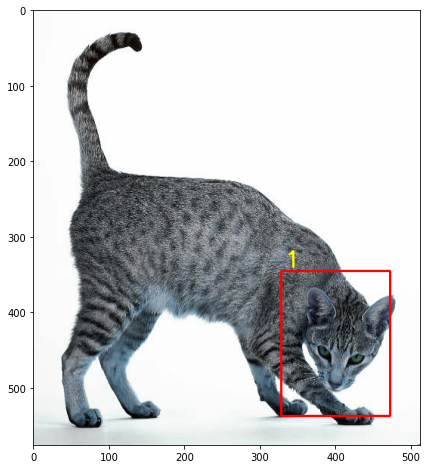

In [18]:
img_with_boxes = plot_img_fastrcnn(img_path, my_model)
fig = plt.figure(figsize=(18,8))
plt.imshow(img_with_boxes.astype('uint'));

Результат обучения "пустой" модели за 16 эпох представлен ниже. Планировал обучить 20 эпох, но Коллаб сказал что с меня хватит и закрыл доступ к GPU. Поэтому модель сохранить не успел, а таблицу составил из логов к обучению.

In [ ]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    start = time.time()
    train_loss = train(train_loader, my_model, optimizer)
    mean_acc, mean_iou = validate(valid_loader, my_model)
    print(f"Эпоха #{epoch} train_loss: {train_loss}, mean accuracy: {mean_acc}, mIoU: {mean_iou}")   
    end = time.time()
    print("Время затрачено на эпоху : ", str(datetime.timedelta(seconds=(end - start))))
    print()
print(f"Размер тренировочного сета : {len(train_idx)}, валидационного сета : {len(val_idx)}")

Iteration #0 train_loss: 2.1223034858703613
Iteration #50 train_loss: 0.8436545729637146
Iteration #100 train_loss: 0.7480248212814331
Iteration #150 train_loss: 0.558888852596283
Iteration #200 train_loss: 0.5589836239814758
Iteration #250 train_loss: 0.6917626261711121
Iteration #300 train_loss: 0.4250752329826355
Epoch #0 train_loss: 0.02887667901813984
Precision :
{'Car': 0.6888019442558289, 'Cyclist': 0.0, 'Truck': 0.0, 'Van': 0.0}
Recall :
{'Car': 0.4758012592792511, 'Cyclist': 0.0, 'Truck': 0.0, 'Van': 0.0}

Mean Average Precision (mAP): 0.172
model saved into: /content/fasterrcnn_resnet50_fpn.pth
Took 16.890883592764535 minutes for epoch 0

Iteration #0 train_loss: 0.6070407629013062
Iteration #50 train_loss: 0.4226641058921814
Iteration #100 train_loss: 0.41042420268058777
Iteration #150 train_loss: 0.477901816368103
Iteration #200 train_loss: 0.4575943648815155
Iteration #250 train_loss: 0.383638471364975
Iteration #300 train_loss: 0.32984423637390137
Epoch #1 train_loss: 0.0